José Javier Hurtarte #19707
Pablo Alejandro Méndez #19195

# Laboratorio 7 - Ataques a modelos
## Ataque de extracción

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.extraction import CopycatCNN
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
import os
import pandas as pd
from keras.utils import image_dataset_from_directory
from keras import models
from keras import layers
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [5]:
tf.compat.v1.disable_eager_execution()

In [6]:
vulnerable_model = tf.keras.models.load_model("original_cnn.h5")

In [69]:
data_location = "../malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = '../model_copysotherselected'

data = []
for family in os.scandir(data_location):
    if family.is_dir:
        for malware in os.scandir(family):
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family"])
df

,name,path,family
0,000bde2e9a94ba41c0c111ffd80647c2.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
1,000e30a0819ac7ed931d629ce2ef8948.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
2,002f06eff1d222560939be72583d6ae9.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
3,0044f0746b812f6b454ce210bc58c572.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
4,0046a83d932a3d431eb21a99b46d6af7.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
...,...,...,...
9334,08a76fe7517aca8a28ece24684855d1d.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9335,08a9e75728b42c9b54a51f6619d8a174.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9336,08acb94708c0dbb3ba53f6766d681453.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9337,08b0bf03f988fd2e1864e34b58713514.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A


In [70]:

df = df.groupby('family', as_index=False, group_keys=False) \
    .apply(lambda s: s.sample(min(70, len(s)), random_state=987654))

In [71]:

for _, row in df.iterrows():
    os.makedirs(os.path.join(selected_images_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(selected_images_location, row['family'], row['name']))

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'c:\\Users\\jjhh1\\OneDrive\\Escritorio\\JJHH\\SDS\\malimg_dataset\\malimg_paper_dataset_imgs\\Adialer.C\\0665bf2861c065285bf2c37c059f39ca.png' -> '../model_copysotherselected\\Adialer.C\\0665bf2861c065285bf2c37c059f39ca.png'

In [72]:

test_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 1750 files belonging to 25 classes.
Using 350 files for validation.
Found 1750 files belonging to 25 classes.
Using 1400 files for training.


In [7]:
clasificador = KerasClassifier(
    model=vulnerable_model
)

In [73]:
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [74]:
blank_model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),     # normalize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data.class_names), activation='softmax')
])

blank_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [75]:

model_stolen = KerasClassifier(
    model=blank_model
)

In [76]:
training_labels = []
training_images = []
for image, label in tfds.as_numpy(training_data):
    training_labels.extend(label)
    training_images.extend(image)

In [78]:

stolen_classifier = copycat_cnn.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1400 samples
Epoch 1/20
1400/1400 [==============================] - 28s 20ms/sample - loss: 3.3016 - accuracy: 0.1143
Epoch 2/20
1400/1400 [==============================] - 24s 17ms/sample - loss: 2.1063 - accuracy: 0.4550
Epoch 3/20
1400/1400 [==============================] - 23s 17ms/sample - loss: 0.9585 - accuracy: 0.7679
Epoch 4/20
1400/1400 [==============================] - 24s 17ms/sample - loss: 0.5397 - accuracy: 0.8579
Epoch 5/20
1400/1400 [==============================] - 25s 18ms/sample - loss: 0.4298 - accuracy: 0.8629
Epoch 6/20
1400/1400 [==============================] - 23s 16ms/sample - loss: 0.2892 - accuracy: 0.9100
Epoch 7/20
1400/1400 [==============================] - 23s 16ms/sample - loss: 0.1971 - accuracy: 0.9243
Epoch 8/20
1400/1400 [==============================] - 23s 16ms/sample - loss: 0.1657 - accuracy: 0.9257
Epoch 9/20
1400/1400 [==============================] - 24s 17ms/sample - loss: 0.1643 - accuracy: 0.9507
Epoch 10/20
1400/1400 [=

In [83]:
probabilities = []
true_labels = []

test_images, test_labels = zip(*tfds.as_numpy(test_data))
for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = clasificador.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch)

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

predicted_labels = np.argmax(probabilities, axis=-1)




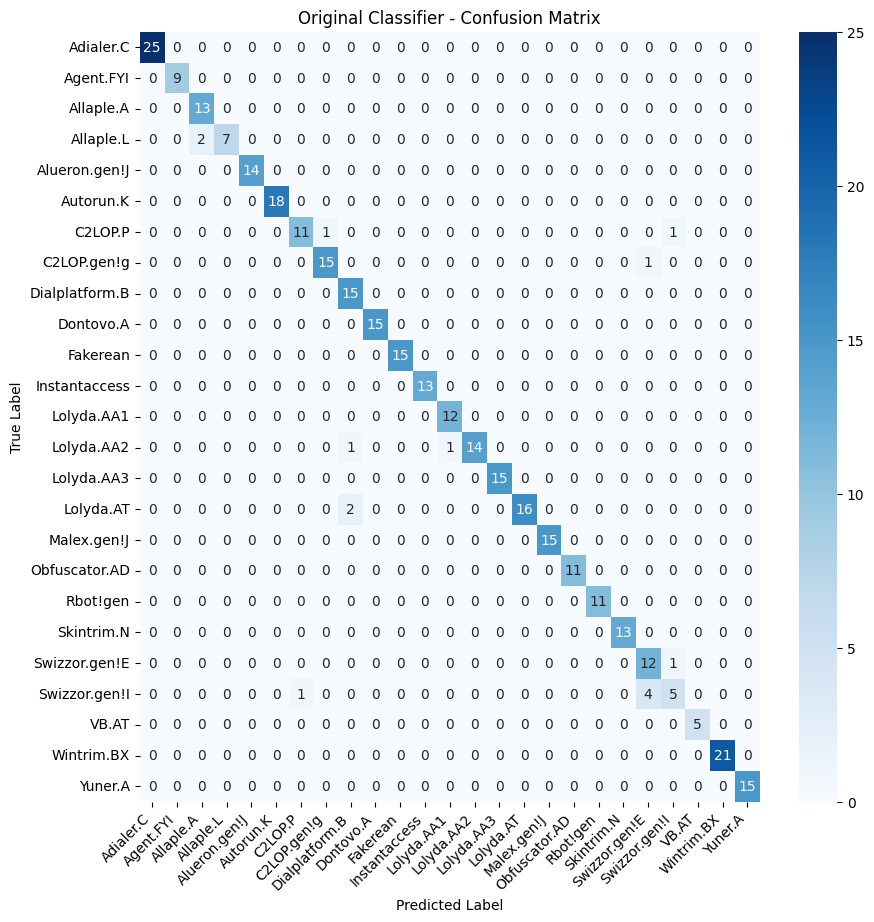

In [88]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier - Confusion Matrix')
plt.show()

In [89]:
probabilities = []
true_labels = []

for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch)

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

predicted_labels = np.argmax(probabilities, axis=-1)

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


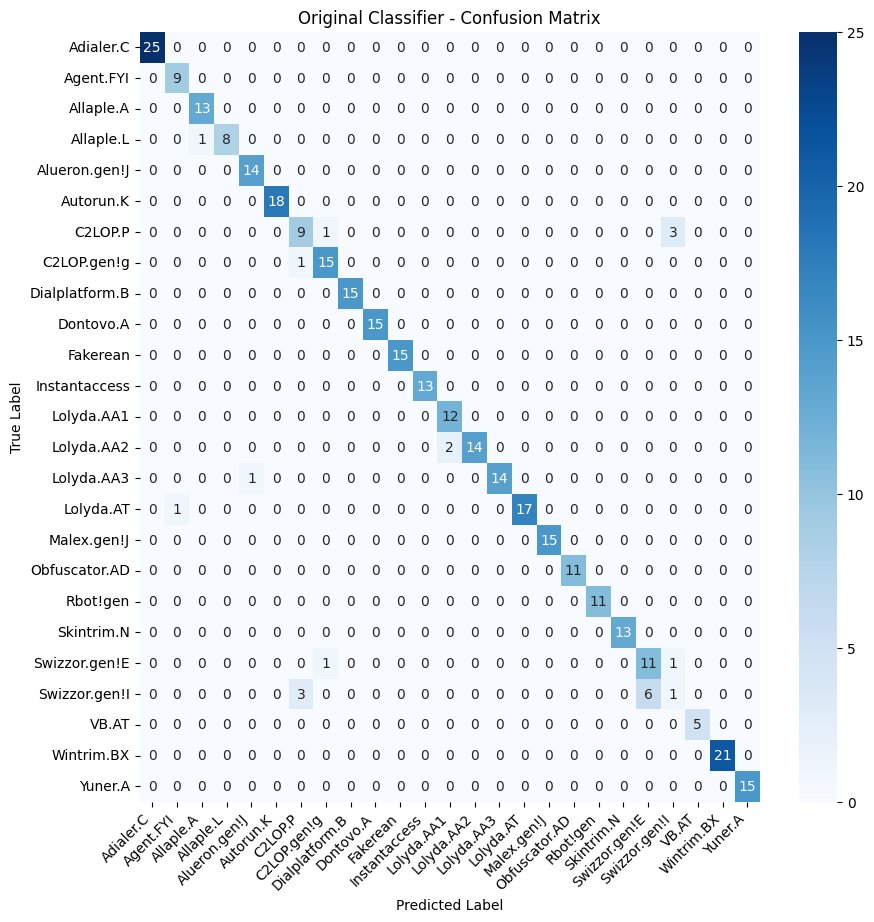

In [90]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stolen Classifier - Confusion Matrix')
plt.show()

Se puede observar que el modelo copiado tiene un comportamiento muy similar al modelo original. Sin embargo, probablemente por haber sido entrenado con una menor cantidad de datos, el modelo copiado tuvo un peor desempeño. Este peor desempeño se destacaca con la clase Swizzor.gen!l; específicamente, algunos miembros de esta familia fueron erróneamente catalogados en otras clases como C2LOP.P y Swizzor.gen!E. 

En conclusión, si se ignoran los aspectos legales y éticos, el robo de modelos es un método económicamente rentable. Después de todo, el mayor costo para entrenar un modelo es conseguir los datos ya clasisficados. Entonces, al necesitar una menor cantidad de datos (incluso sin clasificar) reduce los costos de manera significativa. Asimismo, aunque el modelo robado desempeñe peor que el modelo original, todavía puede alcanzar métricas satisfactorias.

In [91]:
# save 
stolen_classifier.save("stolen_cnn.h5")

## Ataque de envenenanmiento

In [11]:
data_location = "../malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = '../model_copysotherselected'

test_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    seed=191919,
)

test_labels = []
test_images = []
for image, label in tfds.as_numpy(test_data):
    test_labels.extend(label)
    test_images.extend(image)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

Found 1750 files belonging to 25 classes.


In [30]:
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.9,
)

In [31]:
test_images_mal = attack_fgsm.generate(x=np.array(test_images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

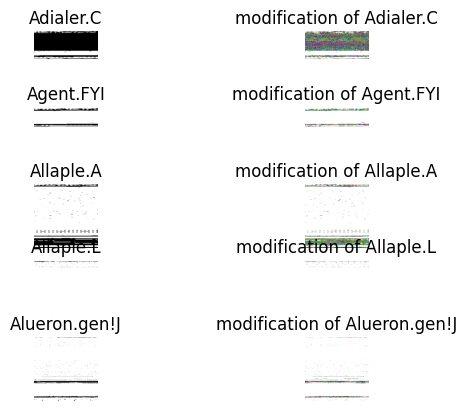

In [32]:
for i in range(5):
    original = test_images[i]
    modified = test_images_mal[i]
    label = test_data.class_names[i]

    plt.subplot(5, 2, i*2+1)
    plt.imshow(original)
    plt.title(label)
    plt.axis('off')

    plt.subplot(5, 2, i*2+2)
    plt.imshow(modified)
    plt.title(f"modification of {label}")
    plt.axis('off')
plt.show()

In [33]:
probabilities = clasificador.predict(test_images)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

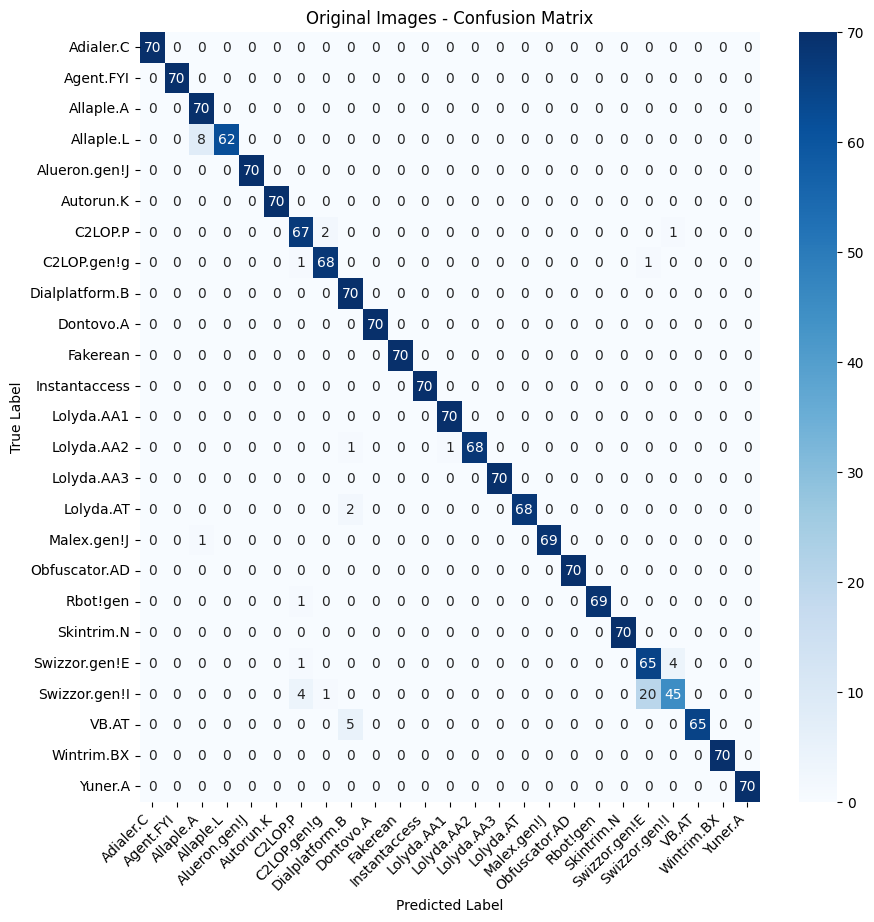

In [34]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Images - Confusion Matrix')
plt.show()

In [35]:
probabilities = clasificador.predict(test_images_mal)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

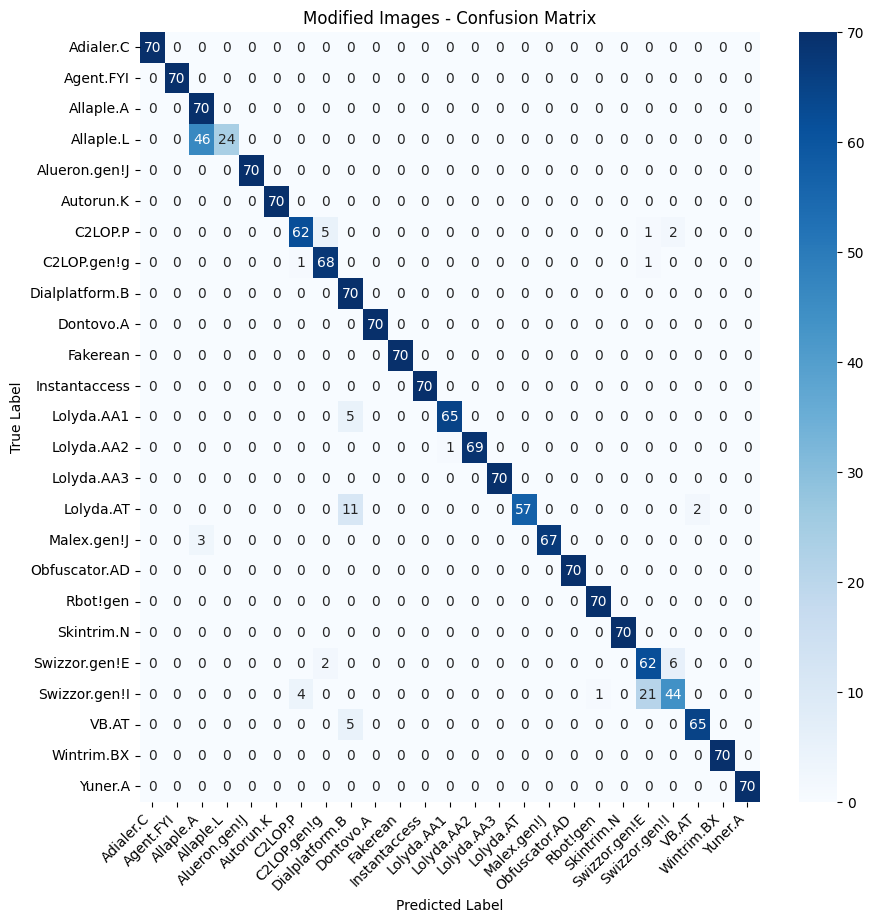

In [37]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Modified Images - Confusion Matrix')
plt.show()

Se demostró que el modelo es resistente a alteraciones a las imágenes, por lo menos, en modificaciones de gamma. Cabe mencionar que, como se puede ver al tener la imagen original y la imagen alterada a la par, se observa que todas las características distintivas de cada familia siguen estando presente. Sería interesante observar cómo se comportaría el modelo con otro tipo de alteración de imágenes. 

La única diferencia en el comportamiento fue que tuvo más falsos negativos. Es decir algunos individuos de familias como Allaple.L y Malex.gen!J  fueron erróneamente clasificadas en otras familias.